# H&M Personalized Fashion 1/2 - Exploratory Data Analysis

---

## Introduction

__H&M Group__ is a family of brands and businesses with 53 online markets and approximately 4,850 stores. The online store offers shoppers an extensive selection of products to browse through. But with too many choices, customers might not quickly find what interests them or what they are looking for, and ultimately, they might not make a purchase. To enhance the shopping experience, __product recommendations are key__. More importantly, helping customers make the right choices also has a positive implications for sustainability, as it reduces returns, and thereby minimizes emissions from transportation.

The goal of this data science challenge is to develop product recommendations __based on data from previous transactions, as well as from customer and product meta data__. The available meta data spans from simple data, such as garment type and customer age, to text data from product descriptions, to image data from garment images. _Here we're not going to use the images_.


This project is divided in 2 parts:
  - the first one (this notebook) is an EDA in order to gain insights from the available datasets, and to know how to prepare the dataset for the 2nd step
  - in a second notebook: we'll use the python library _LightFM_ to build different recommendations models.

---

## First insight

Let's start by importing all the libraries we're going to use, and load the three datasets relative to the customers, articles and transactions:

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# plotly as pandas backend
# pd.options.plotting.backend = "plotly"



import os
from scipy import sparse

ENV = "COLAB"  # "LOCAL"  #

if ENV == "COLAB":
    from google.colab import drive
    drive.mount('/content/drive')
    dir_path = "drive/MyDrive/recomm/projet/"
else:
    dir_path = "../../../dataset/"


file_customers = "customers.csv"
file_articles = "articles.csv"
file_transactions = "transactions_train.csv"


df_customers = pd.read_csv(dir_path + file_customers)
df_articles = pd.read_csv(dir_path + file_articles)
df_transactions = pd.read_csv(dir_path + file_transactions)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Usually informations on the customers are more used for marketings (clustering / segmentation & KYC) purpose rather than for building the recommendation system. In order to get a big picture, we can start by a description of each datasets' features (type, number & percentage of missing values, number & percentage of unique values and so on):

__Metadata for each `customer_id` in dataset__

In [ ]:
def describe_df(df):
    list_item = []
    for col in df.columns:
        list_item.append([
            col,
            df[col].dtype,
            df[col].isna().sum(),
            round(df[col].isna().sum()/len(df[col])*100, 2),
            df[col].nunique(),
            round(df[col].nunique()/len(df[col])*100, 2),
            list(df[col].unique()[:5])
        ])
    return pd.DataFrame(
        columns=['feature', 'type', '# null', '% null', '# unique', '% unique', 'sample'],
        data = list_item
    )


assert df_customers.customer_id.nunique() == df_customers.shape[0]
describe_df(df_customers)

,feature,type,# null,% null,# unique,% unique,sample
0,customer_id,object,0,0.00,1371980,100.00,[00000dbacae5abe5e23885899a1fa44253a17956c6d1c...
1,FN,float64,895050,65.24,1,0.00,"[nan, 1.0]"
2,Active,float64,907576,66.15,1,0.00,"[nan, 1.0]"
3,club_member_status,object,6062,0.44,3,0.00,"[ACTIVE, nan, PRE-CREATE, LEFT CLUB]"
4,fashion_news_frequency,object,16009,1.17,4,0.00,"[NONE, Regularly, nan, Monthly, None]"
5,age,float64,15861,1.16,84,0.01,"[49.0, 25.0, 24.0, 54.0, 52.0]"
6,postal_code,object,0,0.00,352899,25.72,[52043ee2162cf5aa7ee79974281641c6f11a68d276429...


__Detailed metadata for each article_id available for purchase:__


This database contains information about the assortiment of H&M shops.

Unique indentifier of an article:
- `article_id` (int64) - an unique 9-digit identifier of the article, 105 542 unique values (as the length of the database)

5 product related columns:
- `product_code` (int64) - 6-digit product code (the first 6 digits of article_id, 47 224 unique values
- `prod_name` (object) - name of a product, 45 875 unique values
- `product_type_no` (int64) - product type number, 131 unique values
- `product_type_name` (object) - name of a product type, equivalent of product_type_no
- `product_group_name` (object) - name of a product group, in total 19 groups


2 columns related to the pattern:

- `graphical_appearance_no` (int64) - code of a pattern, 30 unique values
- `graphical_appearance_name` (object) - name of a pattern, 30 unique values

2 columns related to the color:

- `colour_group_code` (int64) - code of a color, 50 unique values
- `colour_group_name` (object) - name of a color, 50 unique values

4 columns related to perceived colour (general tone):

- `perceived_colour_value_id` - perceived color id, 8 unique values
- `perceived_colour_value_name` - perceived color name, 8 unique values
- `perceived_colour_master_id` - perceived master color id, 20 unique values
- `perceived_colour_master_name` - perceived master color name, 20 unique values

2 columns related to the department:

- `department_no` - department number, 299 unique values
- `department_name` - department name, 299 unique values

4 columns related to the index, which is actually a top-level category:

- `index_code` - index code, 10 unique values
- `index_name` - index name, 10 unique values
- `index_group_no` - index group code, 5 unique values
- `index_group_name` - index group code, 5 unique values

2 columns related to the section:

- `section_no` - section number, 56 unique values
- `section_name` - section name, 56 unique values

2 columns related to the garment group:

- `garment_group_n` - section number, 56 unique values
- `garment_group_name` - section name, 56 unique values

1 column with a detailed description of the article:

- `detail_desc` - 43 404 unique values

In [ ]:
assert df_articles.article_id.nunique() == df_articles.shape[0]
describe_df(df_articles)

,feature,type,# null,% null,# unique,% unique,sample
0,article_id,int64,0,0.00,105542,100.00,"[108775015, 108775044, 108775051, 110065001, 1..."
1,product_code,int64,0,0.00,47224,44.74,"[108775, 110065, 111565, 111586, 111593]"
2,prod_name,object,0,0.00,45875,43.47,"[Strap top, Strap top (1), OP T-shirt (Idro), ..."
3,product_type_no,int64,0,0.00,132,0.13,"[253, 306, 304, 302, 273]"
4,product_type_name,object,0,0.00,131,0.12,"[Vest top, Bra, Underwear Tights, Socks, Leggi..."
5,product_group_name,object,0,0.00,19,0.02,"[Garment Upper body, Underwear, Socks & Tights..."
6,graphical_appearance_no,int64,0,0.00,30,0.03,"[1010016, 1010017, 1010001, 1010010, 1010019]"
7,graphical_appearance_name,object,0,0.00,30,0.03,"[Solid, Stripe, All over pattern, Melange, Tra..."
8,colour_group_code,int64,0,0.00,50,0.05,"[9, 10, 11, 12, 13]"
9,colour_group_name,object,0,0.00,50,0.05,"[Black, White, Off White, Light Beige, Beige]"


the training data, consisting of the purchases each customer for each date, as well as additional information. Duplicate rows correspond to multiple purchases of the same item. Our task is to predict the `article_id` each customer will purchase :

In [ ]:
df_transactions.t_dat = pd.to_datetime(df_transactions.t_dat, infer_datetime_format=True)
describe_df(df_transactions)

,feature,type,# null,% null,# unique,% unique,sample
0,t_dat,datetime64[ns],0,0.0,734,0.00,"[2018-09-20T00:00:00.000000000, 2018-09-21T00:..."
1,customer_id,object,0,0.0,1362281,4.29,[000058a12d5b43e67d225668fa1f8d618c13dc232df0c...
2,article_id,int64,0,0.0,104547,0.33,"[663713001, 541518023, 505221004, 685687003, 6..."
3,price,float64,0,0.0,9857,0.03,"[0.0508305084745762, 0.0304915254237288, 0.015..."
4,sales_channel_id,int64,0,0.0,2,0.00,"[2, 1]"


---
## Focus on Customers

The metadata for each `customer_id` in the dataset consists of `club member status`, whether they `subscribe` to fashion news or not, and `age`. Some types are wrong due to missing values:

In [ ]:
print(f"there are {(df_customers.age != df_customers.age.round()).sum()} customers whose age is not an integer")
print(f"there are {df_customers.age.isnull().sum()} ages missing")

there are 15861 customers whose age is not an integer
there are 15861 ages missing


Missing ages are arbitrarily replaced by 0 so that unknow values can be distinguished:

In [ ]:
mapping = {"FN": 0, "Active": 1, "club_member_status": "N.C", "fashion_news_frequency": "N.C", "age": 0}

df_customers.fillna(value=mapping, inplace=True)
df_customers.drop(columns="postal_code", inplace=True)

for col in ["FN", "age", "Active"]:
    df_customers[col] = df_customers[col].astype(np.int8)

Now let's see the ratios of the number of customers for each feature:

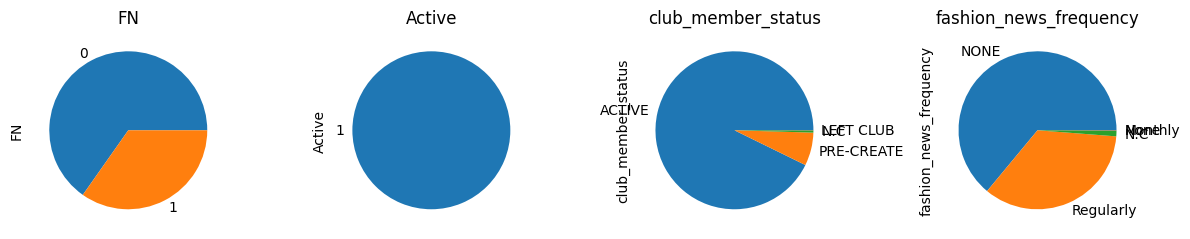

In [ ]:
cols = ["FN", "Active", "club_member_status", "fashion_news_frequency"]
fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=(12, 6), tight_layout=True)

for i, c in enumerate(cols):
  df_customers[c].value_counts().plot.pie(ax=axes[i], title=c)

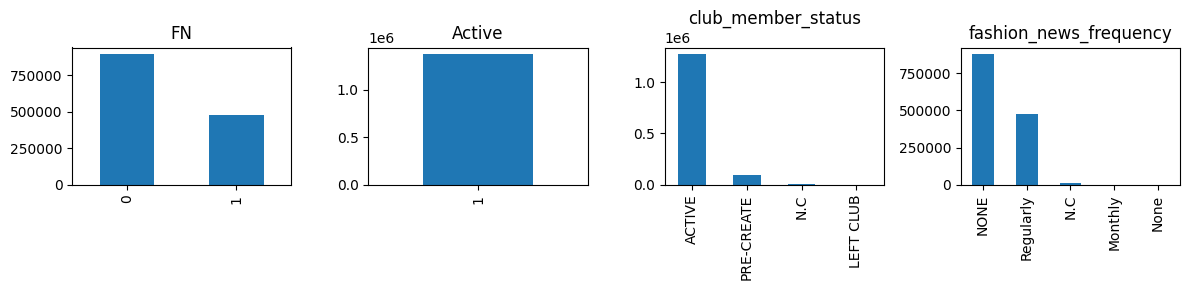

In [ ]:
cols = ["FN", "Active", "club_member_status", "fashion_news_frequency"]
fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=(12, 3), tight_layout=True)

for i, c in enumerate(cols):
  df_customers[c].value_counts().plot.bar(ax=axes[i], title=c)

By visualizing the distribution of the age, we can clearly see that:
- there are two types of clients: between 20 & 40, and older than 40 yrs old.
- the number of missing values isn't too high

<Axes: xlabel='age', ylabel='Count'>

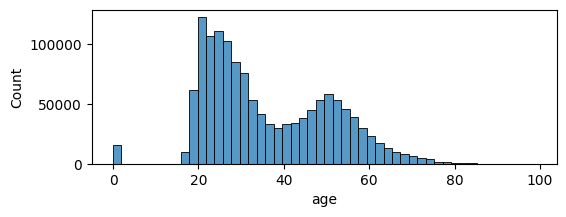

In [ ]:
plt.figure(figsize=(6, 2))
sns.histplot(data=df_customers, x='age', bins=50)

The shape of the age distribution remains quite the same for each category of customer:

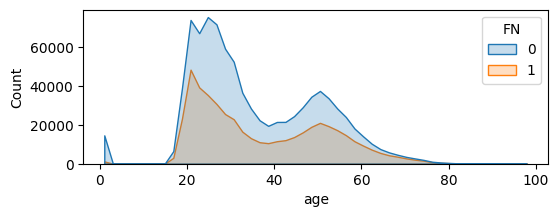

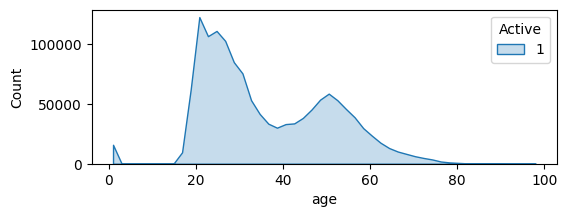

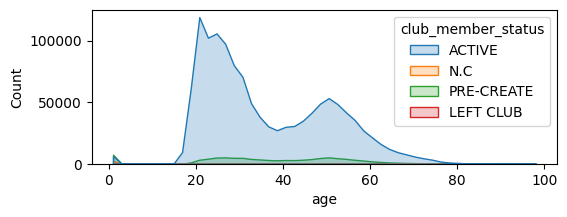

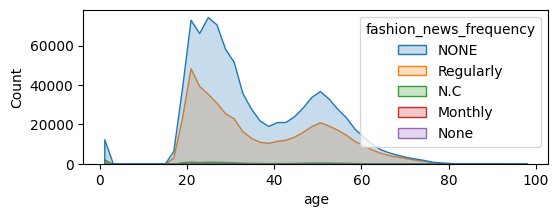

In [ ]:
for c in cols:
  plt.figure(figsize=(6, 2))
  sns.histplot(data=df_customers, x='age', bins=50, hue=c, element="poly")
  plt.show()

---

## Focus on Articles


With a sunburst chart, we visualize the hierarchical structures of the different clothes' categories:
- the "sport" category is the least represented
- while the "ladieswear" & the "baby/children" seem to be the most important
- unlike the "ladieswear" composed mostly of "Garment Upper Body", the "baby/children" clothes are more diversified:

In [ ]:
cols = ["index_group_name", "index_name",  "product_group_name"]
df_temp = pd.DataFrame(df_articles[cols].value_counts()).rename(columns={0: "counts"}).reset_index()
px.sunburst(
    df_temp,
    path=cols,
    values='counts',
)

![](01_img/05.png)

If we don't group those clothes by `index_group` by rather by `product type`, we can see that the most represented product are: dresses, sweaters, swim wear bodies & trousers:

In [ ]:
def plot_bar(df, column):
    long_df = pd.DataFrame(df.groupby(column)['article_id'].count().reset_index().rename({'article_id': 'count'}, axis=1))
    fig = px.bar(long_df, x=column, y="count", color=column, title=f"bar plot for {column} ", width=900, height=550)
    fig.show()

def plot_hist(df, column):
    fig = px.histogram(df, x=column, nbins=10, title=f'{column} distribution ')
    fig.show()


plot_bar(df_articles,'product_type_name')

![](01_img/06.png)

In [ ]:
plot_bar(df_articles,'product_group_name')

![](01_img/07.png)

In [ ]:
plot_bar(df_articles,'graphical_appearance_name')

![](01_img/08.png)

# Focus an Transactions



Most item catalogs exhibit the long tail effect (popularity bias): very few items are demanded & sold, whereas most of the articles aren't sold that much.

<Axes: >

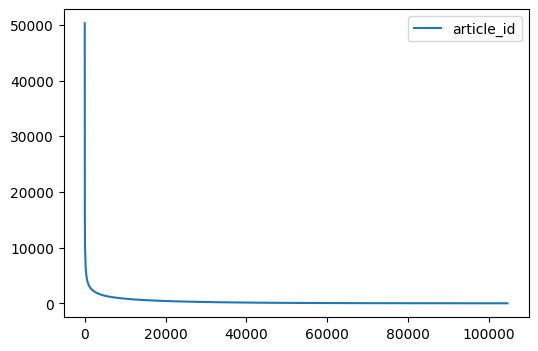

In [ ]:
df_transactions['article_id'].value_counts().reset_index().drop(columns=["index"]).plot(figsize=(6, 4))

Curiously, the same is also true for customers. This can be explained by the fact that few customers are in fact societies or resellers that buy high volumnes of items, where as the vast majority of the customers have only bought 1 or 2 items:

<Axes: >

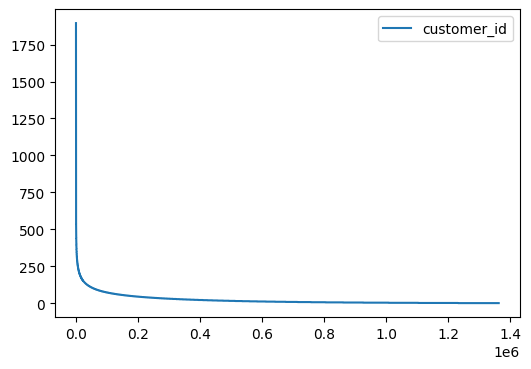

In [ ]:
df_transactions['customer_id'].value_counts()\
  .reset_index().sort_index().plot(figsize=(6, 4))

The history of transactions spans three years:

In [ ]:
df_transactions["t_dat"].dt.year.unique()

array([2018, 2019, 2020])

Few spikes can be observed from the total daily sales, and can be explained by the shopping events or highly promoted sales at discounted price such as the "black friday":

In [ ]:
df_transactions['month'] = df_transactions["t_dat"].dt.month
df_transactions['year'] = df_transactions["t_dat"].dt.year
df_transactions['dow'] = df_transactions["t_dat"].dt.day_name()

df_temp = df_transactions.groupby('t_dat')['price'].agg(['sum', 'mean']).sort_values(by = 't_dat', ascending=False).reset_index()
px.line(df_temp, x='t_dat', y='sum', title='Total Sales daily', width=900, height=450).show()

![](01_img/11.png)

The count of monthly sells shows that more items are sold during the summer (remember the swim wear body as most demanded):

In [ ]:
df_temp = df_transactions.groupby(['year', 'month']).count()["article_id"].reset_index().rename(columns={"article_id": "count"})
px.line(df_temp, x="month", y="count", color='year', width=900, height=350, markers=True)

![](01_img/12.png)

2018 is an incomplete year in our dataset, that's why there are fewer sells monthly. But there are also fewer monthly sells in 2020 compared to 2019 for the month

In [ ]:
df_temp = df_transactions.groupby(["year", "month"]).agg({"price": "sum"}).reset_index()

px.histogram(
    df_temp,
    x="month",
    y="price",
    title='Monthly sells for each year',
    color='year',
    barmode='group',
    nbins=12,
    width=900,
    height=450
).show()

![](01_img/13.png)

In [ ]:
df_temp = df_transactions.groupby(["year", "dow"]).agg({"price": "sum"}).reset_index()

px.histogram(
    df_temp,
    x="dow",
    y="price",
    title='Daily sells for each year',
    color='year',
    barmode='group',
    nbins=10,
    width=900,
    height=450
).show()

![](01_img/14.png)

---
## Transactions analysis for different customers or articles categories

Let's keep only few months for the sake of simplicity (and also because it's quite hard to process huge amount of data with limited ressources):

In [ ]:
df = df_transactions[(df_transactions.t_dat.dt.year == 2019) & (df_transactions.t_dat.dt.month.isin([5, 6, 7, 9]))]
df.shape

(6501193, 8)

In [ ]:
df_transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id,month,year,dow
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,9,2018,Thursday
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,9,2018,Thursday
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,9,2018,Thursday
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2,9,2018,Thursday
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2,9,2018,Thursday


In [ ]:
df = df.merge(df_articles[["article_id", "index_group_name", "index_name", "section_name"]], on='article_id')
df.drop(columns=["article_id"], inplace=True)#, "month", "year"])
del df_articles


df = df.merge(df_customers, on='customer_id')
df.drop(columns=["customer_id"], inplace=True)
del df_customers


# df.drop(columns=["postal_code"], inplace=True)
df['month'] = df.t_dat.dt.month
# df['year'] = df.t_dat.dt.year
df['dow'] = df.t_dat.dt.day_name
print(f"Total Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
df.head()

Total Memory Usage: 2751.01 MB


,t_dat,price,sales_channel_id,month,year,dow,index_group_name,index_name,section_name,FN,Active,club_member_status,fashion_news_frequency,age
0,2019-05-01,0.050831,2,5,2019,<bound method PandasDelegate._add_delegate_acc...,Divided,Divided,Ladies Denim,0,1,PRE-CREATE,NONE,55
1,2019-05-01,0.050831,2,5,2019,<bound method PandasDelegate._add_delegate_acc...,Ladieswear,Ladieswear,Womens Everyday Collection,0,1,PRE-CREATE,NONE,55
2,2019-05-01,0.016932,2,5,2019,<bound method PandasDelegate._add_delegate_acc...,Ladieswear,Lingeries/Tights,Womens Lingerie,0,1,PRE-CREATE,NONE,55
3,2019-05-01,0.033881,2,5,2019,<bound method PandasDelegate._add_delegate_acc...,Ladieswear,Ladieswear,Womens Everyday Collection,0,1,PRE-CREATE,NONE,55
4,2019-05-01,0.016932,2,5,2019,<bound method PandasDelegate._add_delegate_acc...,Ladieswear,Ladieswear,Womens Everyday Collection,0,1,PRE-CREATE,NONE,55


In [ ]:
df['dow'] = df["t_dat"].dt.day_name()


def plot_var_accross_time(var):
  for time_scale in ['month', 'dow']:
    df_temp = df.groupby([time_scale, var]).count()["t_dat"].reset_index().rename(columns={"t_dat": "count"})
    px.line(df_temp, x=time_scale, y="count", color=var, width=900, height=350, markers=True, title=f'Evolution of transactions for different {var} for each {time_scale} over 2019').show()


plot_var_accross_time("index_group_name")

![](01_img/15.png)

In [ ]:
plot_var_accross_time("index_name")

![](01_img/16.png)

In [ ]:
plot_var_accross_time("Active")

![](01_img/18.png)